# Name Entity Recognition - Project
***Student: Anh Thu VU - 21322736***

This project aims to train a NER model being able to identify 10 annotated labels from the [**QUAERO French Medical Corpus**](https://quaerofrenchmed.limsi.fr/) dataset:
- Anatomy (ANAT)
- Chemical and Drugs (CHEM)
- Devices (DEVI)
- Disorders (DISO)
- Geographic Areas (GEOG)
- Living Beings (LIVB)
- Objects (OBJC)
- Phenomena (PHEN)
- Physiology (PHYS)
- Procedures (PROC)

In [ ]:
!pip install jupyter_black
!pip install "packaging==21.3"
!pip install "black==22.1.0"
!pip install "edsnlp[ml]==0.15.0"
%reload_ext jupyter_black

In [ ]:
# Import necessary packages
from spacy import displacy
import edsnlp
from typing import List, Dict, Tuple, Iterable
from spacy.tokens import Doc, Span
from spacy import Language
from confit.utils.random import set_seed
from edsnlp.pipes.misc.split.split import subset_doc
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import torch
from itertools import chain, repeat
from tqdm import tqdm
from accelerate import Accelerator
import warnings

set_seed(42)

In [ ]:
# Filter the warnings
warnings.filterwarnings(
    "ignore",
    message=r"Some spans were discarded.*because they were overlapping with other spans with the same label",
    category=UserWarning,
    module=r"edsnlp\.pipes\.trainable\.ner_crf\.ner_crf",
)

## Training, validation, and test dataset
Since the evaluation will be made on the **EMEA test dataset**, the model will be trained on a dataset consisting of the **MEDLINE dataset (train, dev, and test)** and the **EMEA train dataset**. Additionally, the **EMEA dev dataset** will be used to tune the model's hyperparameters.

### Convert data in BRAT standoff format into spaCy Doc
#### How does a Doc.spans look like?

In [ ]:
docs_with_all_labels = list(
    edsnlp.data.read_standoff(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/dev/MEDLINE",
        span_setter=["ents", "sc", "*"],
    )
)

2025-04-06 04:49:22.689 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.


In [ ]:
print(docs_with_all_labels[1].spans)
displacy.render(docs_with_all_labels[1], style="span")

{'sc': [Tuberculose médiastinale ganglionnaire, Tuberculose médiastinale, Tuberculose, médiastinale, ganglionnaire], 'DISO': [Tuberculose médiastinale ganglionnaire, Tuberculose médiastinale, Tuberculose], 'ANAT': [médiastinale, ganglionnaire]}


Since the **EMEA dataset** contains very long texts, it is necessary to split each doc into sub-docs of reasonable size. To achieve this, the pipeline `eds.sentences` will be used to split the doc into sentences. It is important to note that each sentence is of type `spaCy.Span`, meaning that the entities within the sentence are not retained. As a result, the data is not immediately ready for training the NER model.

To address this, the function `subset_doc` ([documentation](https://aphp.github.io/edsnlp/latest/reference/edsnlp/pipes/misc/split/split/#edsnlp.pipes.misc.split.split.subset_doc)) will be used to convert each sentence into a `spaCy.Doc`, and now all entities in the sentence are stored in its `spans` attribute.  

In [ ]:
def convert_brat_to_doc(
    data_path: str, nlp: Language, skip_empty: bool = True, split: bool = False
):
    """
    Parameters:
        - data_path: Path to BRAT data folder
        - nlp: The trained NER model
        - skip_empty: If skip_empty is True, skip the doc that has no entities
        - split: If split is True, split the doc into sentences
    """
    doc_iterator = edsnlp.data.read_standoff(
        data_path,
        span_setter=["ents", "sc", "*"],
        tokenizer=nlp.tokenizer,  # Tokenize the docs with the same tokenizer as the trained model
    )

    sentencizer = edsnlp.blank("eds")
    sentencizer.add_pipe("eds.sentences")

    for doc in doc_iterator:
        if skip_empty and len(doc.spans["sc"]) == 0:
            continue  # Skip the doc with no annotations
        else:
            if not split:
                yield doc
            else:
                # Split the doc into sentences
                doc = sentencizer(doc)
                for sent in doc.sents:
                    start_tok = sent.start
                    end_tok = sent.end
                    sub_doc = subset_doc(doc, start_tok, end_tok)  # Retain the entities
                    if skip_empty:
                        if len(sub_doc.spans["sc"]) == 0:
                            continue  # Skip the sub-doc with no annotations
                    yield sub_doc

#### Sanity check
In this section, we will check to ensure that the `convert_brat_to_doc` function successfully split the **EMEA dataset** into sentences and retained all entities.

In [ ]:
def count_spans(
    split_docs: Iterable[Doc], original_docs: Iterable[Doc]
) -> Tuple[int, int]:
    """
    Count the number of entities in the split and original dataset
    """
    nb_spans_split = 0
    nb_spans_original = 0
    for doc in split_docs:
        nb_spans_split += len(doc.spans["sc"])
    for doc in original_docs:
        nb_spans_original += len(doc.spans["sc"])
    return nb_spans_split, nb_spans_original

In [ ]:
# EMEA train
nlp = edsnlp.blank("eds")
split_docs = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA", nlp, split=True
)
original_docs = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA", nlp, split=False
)

nb_spans_split, nb_spans_original = count_spans(split_docs, original_docs)
print("The number of entities in the split dataset: ", nb_spans_split)
print("The number of entities in the original dataset: ", nb_spans_original)

2025-04-06 04:49:37.078 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 04:49:39.148 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.


The number of entities in the split dataset:  2723
The number of entities in the original dataset:  2723


In [ ]:
# EMEA dev
nlp = edsnlp.blank("eds")
split_docs = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/dev/EMEA", nlp, split=True
)
original_docs = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/dev/EMEA", nlp, split=False
)

nb_spans_split, nb_spans_original = count_spans(split_docs, original_docs)
print("The number of entities in the split dataset: ", nb_spans_split)
print("The number of entities in the original dataset: ", nb_spans_original)

2025-04-06 04:49:39.282 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
2025-04-06 04:49:40.425 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.


The number of entities in the split dataset:  2275
The number of entities in the original dataset:  2275


In [ ]:
# EMEA test
nlp = edsnlp.blank("eds")
split_docs = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA", nlp, split=True
)
original_docs = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA", nlp, split=False
)

nb_spans_split, nb_spans_original = count_spans(split_docs, original_docs)
print("The number of entities in the split dataset: ", nb_spans_split)
print("The number of entities in the original dataset: ", nb_spans_original)

2025-04-06 04:49:40.562 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 04:49:41.466 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.


The number of entities in the split dataset:  2246
The number of entities in the original dataset:  2246


In [ ]:
# Visualize entities
print("-----Entities in a subdoc after splitting-----\n")
nlp = edsnlp.blank("eds")
doc_iterator = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA", nlp, split=True
)
doc_test = list(doc_iterator)[2]
displacy.render(doc_test, style="span")

print("\n-----Entities in the original doc-----\n")
doc_iterator = edsnlp.data.read_standoff(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA",
    span_setter=["ents", "sc", "*"],
    tokenizer=nlp.tokenizer,
)
doc_test = list(doc_iterator)[0]
displacy.render(doc_test, style="span")

2025-04-06 04:49:41.581 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.


-----Entities in a subdoc after splitting-----



2025-04-06 04:49:43.348 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.



-----Entities in the original doc-----



## Helper functions
This section contains all helper functions necessary for processing data and evaluating the model's performance.

In [ ]:
def process_docs(nlp: Language, docs: List[Doc]) -> List[Doc]:
    """
    Process a list of documents and return a list of predicted documents
    """
    pred_docs = []
    for doc in docs:
        # Process the doc
        pred_doc = nlp(doc.text)  # Process only the text without the annotations
        pred_docs.append(pred_doc)

    return pred_docs

In [ ]:
def is_match(true_ent: Span, pred_ent: Span, matching_mode: str = "exact") -> bool:
    """
    Return True if the predicted entity matches the ground truth entity.
    If matching_mode = "exact": Returns True when the entity boundaries are exactly the same
    If matching_mode = "partial": Return True when the entity boundaries are overlaping
    """
    start_char_true, end_char_true = (true_ent.start_char, true_ent.end_char)
    start_char_pred, end_char_pred = (pred_ent.start_char, pred_ent.end_char)

    if matching_mode == "exact":
        if start_char_pred == start_char_true and end_char_pred == end_char_true:
            return True
        else:
            return False

    elif matching_mode == "partial":
        if start_char_pred >= end_char_true or end_char_pred <= start_char_true:
            return False
        else:
            return True

    else:
        raise ValueError(
            f"Expecting matching_mode to be 'exact' or 'partial' and not {matching_mode}"
        )

In [ ]:
def compute_metrics(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    """
    From the number of True Positive (TP), False Postive (FP), and False Negative (FN),
    compute the precision, recall and F1-score.
    """
    # Precision
    if (tp + fp) == 0:
        precision = 0.0
    else:
        precision = round(tp / (tp + fp), 2)

    # Recall
    if (tp + fn) == 0:
        recall = 0.0
    else:
        recall = round(tp / (tp + fn), 2)

    # F1
    if (precision + recall) == 0:
        f1 = 0.0
    else:
        f1 = round(
            2.0 * (precision * recall) / (precision + recall),
            2,
        )

    return precision, recall, f1

In [ ]:
def evaluate(
    true_docs: List[Doc], pred_docs: List[Doc], matching_mode: str = "exact"
) -> Dict:
    """
    Compare the prediction and ground truth document by document,
    and return the number of TP, FP, and FN,
    as well as the recall, precision, and F1-score for each label and overall
    """
    scores = {
        "overall": {"TP": 0, "FP": 0, "FN": 0},
        "ANAT": {"TP": 0, "FP": 0, "FN": 0},
        "CHEM": {"TP": 0, "FP": 0, "FN": 0},
        "DEVI": {"TP": 0, "FP": 0, "FN": 0},
        "DISO": {"TP": 0, "FP": 0, "FN": 0},
        "GEOG": {"TP": 0, "FP": 0, "FN": 0},
        "LIVB": {"TP": 0, "FP": 0, "FN": 0},
        "OBJC": {"TP": 0, "FP": 0, "FN": 0},
        "PHEN": {"TP": 0, "FP": 0, "FN": 0},
        "PHYS": {"TP": 0, "FP": 0, "FN": 0},
        "PROC": {"TP": 0, "FP": 0, "FN": 0},
    }

    for true_doc, pred_doc in zip(true_docs, pred_docs):
        for true_label, true_spans in true_doc.spans.items():  # true_spans is a list
            if true_label != "sc":  # Exclude the `sc` key
                # Look for a match in the prediction
                if true_label not in pred_doc.spans.keys():
                    scores[true_label]["FN"] += len(true_spans)
                else:
                    pred_spans = pred_doc.spans[true_label]
                    for true_span in true_spans:
                        matched = False
                        for pred_span in pred_spans:
                            if is_match(true_span, pred_span, matching_mode):
                                scores[true_label]["TP"] += 1
                                matched = True
                                break
                        if not matched:
                            scores[true_label]["FN"] += 1

        for pred_label, pred_spans in pred_doc.spans.items():
            if pred_label != "sc":  # Exclude the `sc` key
                # Look for a match in the ground truth
                if pred_label not in true_doc.spans.keys():
                    scores[pred_label]["FP"] += len(pred_spans)
                else:
                    true_spans = true_doc.spans[pred_label]
                    for pred_span in pred_spans:
                        matched = False
                        for true_span in true_spans:
                            if is_match(true_span, pred_span, matching_mode):
                                matched = True
                                break
                        if not matched:
                            scores[pred_label]["FP"] += 1

    # Compute overall TP, FP, and FN
    scores["overall"]["TP"] = sum(
        metrics["TP"] for label, metrics in scores.items() if label != "overall"
    )
    scores["overall"]["FP"] = sum(
        metrics["FP"] for label, metrics in scores.items() if label != "overall"
    )
    scores["overall"]["FN"] = sum(
        metrics["FN"] for label, metrics in scores.items() if label != "overall"
    )

    # Compute Precision, Recall, F1
    for metrics in scores.values():
        metrics["precision"], metrics["recall"], metrics["f1"] = compute_metrics(
            metrics["TP"], metrics["FP"], metrics["FN"]
        )

    return scores

In [ ]:
# Sanity check
nlp = edsnlp.blank("eds")
doc_iterator = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA", nlp, split=True
)
doc_iterator = list(doc_iterator)
evaluate(true_docs=doc_iterator, pred_docs=doc_iterator, matching_mode="exact")

2025-04-06 04:49:44.151 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.


{'overall': {'TP': 2723,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'ANAT': {'TP': 247,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'CHEM': {'TP': 727,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'DEVI': {'TP': 48,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'DISO': {'TP': 762,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'GEOG': {'TP': 22,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'LIVB': {'TP': 273,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'OBJC': {'TP': 71,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'PHEN': {'TP': 19,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'PHYS': {'TP': 119,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'PROC': {'TP': 435,
  'FP': 0,
  'FN': 0,
  'precision': 1.

In [ ]:
def plot_training_loss(
    ax: matplotlib.axes._axes.Axes, train_losses: List[float], title: str
) -> None:
    """
    Plot Training losses
    """
    ax.plot(np.arange(len(train_losses)), train_losses, label=title)

In [ ]:
def store_evaluation_metrics(
    train_scores: List[Dict],
    train_docs: List[Doc],
    val_scores: List[Dict],
    val_docs: List[Doc],
    nlp: Language,
    step: int,
    matching_mode: str = "exact",
) -> None:
    """
    Append evaluation metrics for the training and validation dataset
    at training step `step`
    """
    # Train Precision/Recall/F1
    train_pred_docs = process_docs(nlp=nlp, docs=train_docs)
    train_score = evaluate(
        true_docs=train_docs, pred_docs=train_pred_docs, matching_mode=matching_mode
    )
    train_score["Step"] = step
    train_scores.append(train_score)

    # Val Precision/Recall/F1
    val_pred_docs = process_docs(nlp=nlp, docs=val_docs)
    val_score = evaluate(
        true_docs=val_docs, pred_docs=val_pred_docs, matching_mode=matching_mode
    )
    val_score["Step"] = step
    val_scores.append(val_score)

In [ ]:
def plot_metrics(
    ax: matplotlib.axes._axes.Axes, scores: List[Dict], title: str, label="overall"
) -> None:
    """
    Plot F1-scores for the label `label`
    """
    f1 = []
    steps = []

    for score in scores:
        f1.append(score[label]["f1"])
        steps.append(score["Step"])

    ax.plot(steps, f1, label=title)

In [ ]:
def model_result(
    nlp: Language,
    test_docs: List[Doc],
    column_name: str,
    matching_mode: str = "exact",
    score_type: str = "f1",
) -> pd.DataFrame:
    """
    Process the test dataset by the trained model
    and return a pandas DataFrame with one column
    and 11 rows containing `score_type` scores for each label and overall
    """
    # Evaluate the model on test docs
    test_pred_docs = process_docs(nlp=nlp, docs=test_docs)
    test_scores = evaluate(
        true_docs=test_docs, pred_docs=test_pred_docs, matching_mode=matching_mode
    )

    f1_scores = {label: metrics["f1"] for label, metrics in test_scores.items()}

    # Convert scores list of dict into a row DataFrame with chosen title
    df_scores = pd.DataFrame.from_dict(f1_scores, orient="index", columns=[column_name])

    return df_scores

## Train the model

In [ ]:
def train_NER(
    batch_size: int,
    n_epochs: int,
    lr: float,
    embedding_model: str,
    add_cnn: bool = False,
    kernel_sizes: List[int] = None,
    add_crf: bool = False,
    log_every_step: int = 40,
    log_train_loss: bool = True,
    matching_mode: str = "exact",
):
    # Defining the model
    nlp = edsnlp.blank("eds")

    # CRF
    if add_crf:  # CRF
        mode = "joint"
        window = 0
    else:  # Linear + softmax
        mode = "independent"
        window = 1

    # Embedding
    bert_embedding = {
        "@factory": "eds.transformer",
        "model": embedding_model,  # BERT model
    }
    if add_cnn:
        embedding = {
            "@factory": "eds.text_cnn",  # CNN built on top of the BERT word embedding
            "kernel_sizes": kernel_sizes,
            "embedding": bert_embedding,
        }
    else:
        embedding = bert_embedding

    nlp.add_pipe(
        "eds.ner_crf",
        name="ner",
        config={
            "mode": mode,
            "window": window,
            "embedding": embedding,
            "target_span_getter": [
                "ANAT",
                "CHEM",
                "DEVI",
                "DISO",
                "GEOG",
                "LIVB",
                "OBJC",
                "PHEN",
                "PHYS",
                "PROC",
            ],
        },
    )

    # Prepare training and validation data
    medline_train = convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/MEDLINE",
        nlp,
        split=False,
    )
    medline_dev = convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/dev/MEDLINE",
        nlp,
        split=False,
    )
    medline_test = convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/MEDLINE",
        nlp,
        split=False,
    )
    emea_train = convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA",
        nlp,
        split=True,
    )
    train_docs = (
        list(medline_train) + list(medline_dev) + list(medline_test) + list(emea_train)
    )

    val_docs = list(
        convert_brat_to_doc(
            "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/dev/EMEA",
            nlp,
            skip_empty=False,  # Keep empty docs for an objective evaluation
            split=True,
        )
    )

    # Complete the initialization with the training data
    nlp.post_init(train_docs)

    # Preprocessing the data
    preprocessed = list(
        nlp.preprocess_many(
            train_docs,
            supervision=True,
        )
    )
    dataloader = torch.utils.data.DataLoader(
        preprocessed,
        batch_size=batch_size,
        collate_fn=nlp.collate,
        shuffle=True,
    )

    # Training loop
    n_steps = len(dataloader) * n_epochs
    train_losses = []
    train_scores = []
    val_scores = []
    optimizer = torch.optim.AdamW(
        params=nlp.parameters(),
        lr=lr,
    )
    _, trained_pipes = zip(*nlp.torch_components())
    accelerator = Accelerator()
    [dataloader, optimizer, *trained_pipes] = accelerator.prepare(
        dataloader,
        optimizer,
        *trained_pipes,
    )
    # Loop over the dataloader
    iterator = chain.from_iterable(repeat(dataloader))
    for step in tqdm(range(n_steps), "Training model", leave=True):
        batch = next(iterator)
        optimizer.zero_grad()
        with nlp.cache():
            loss = torch.zeros((), device=accelerator.device)
            for name, pipe in nlp.torch_components():
                output = pipe.module_forward(batch[name])
                if "loss" in output:
                    loss += output["loss"]

        accelerator.backward(loss)
        optimizer.step()

        # Store the training loss every step
        if log_train_loss:
            train_losses.append(loss.item())

        # Store evaluation metrics on Validation and Training dataset
        if log_every_step is not None:
            if step % log_every_step == 0 or step == (n_steps - 1):
                store_evaluation_metrics(
                    train_scores=train_scores,
                    train_docs=train_docs,
                    val_scores=val_scores,
                    val_docs=val_docs,
                    nlp=nlp,
                    step=step,
                    matching_mode=matching_mode,
                )

    return nlp, train_losses, train_scores, val_scores

### Comparison between different models
I would like to note that, because it takes a significant amount of time to fully train a model, I do not thoroughly tuning the hyperparameters in this project. Instead, I run the training for a few epochs to observe the behavior of the training loss, adjust the learning rate if necessary, and then fix the number of training epochs to `15`, in order to compare as many different models as possible.


#### `CamemBERT-bio`

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=1e-4,
    embedding_model="almanach/camembert-bio-base",
    add_cnn=False,
    kernel_sizes=None,
    add_crf=False,
    log_every_step=4000,
    log_train_loss=True,
)

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of CamembertModel were not initialized from the model checkpoint at almanach/camembert-bio-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.32M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

2025-04-06 04:50:05.861 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 04:50:14.370 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 04:50:16.274 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 04:50:25.467 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 04:50:27.609 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [16:11<00:00, 11.60it/s]  


Text(0.5, 0.98, 'CamemBERT-bio')

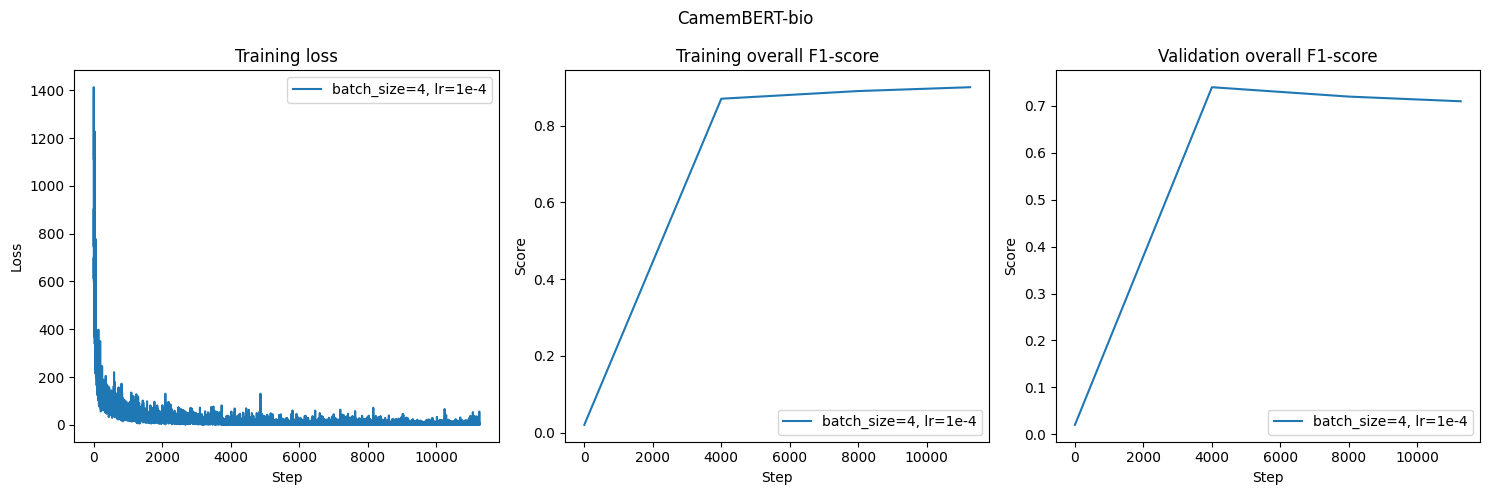

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=1e-4")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("CamemBERT-bio")

In [ ]:
nlp.to_disk("camembert_bio")

#### `CamemBERT-bio` + CRF

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=1e-4,
    embedding_model="almanach/camembert-bio-base",
    add_cnn=False,
    kernel_sizes=None,
    add_crf=True,
    log_every_step=4000,
    log_train_loss=True,
)

Some weights of CamembertModel were not initialized from the model checkpoint at almanach/camembert-bio-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-06 05:06:44.775 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 05:06:46.923 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 05:06:49.392 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 05:06:50.836 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 05:06:52.683 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [18:07<00:00, 10.35it/s]  


Text(0.5, 0.98, 'CamemBERT-bio + CRF')

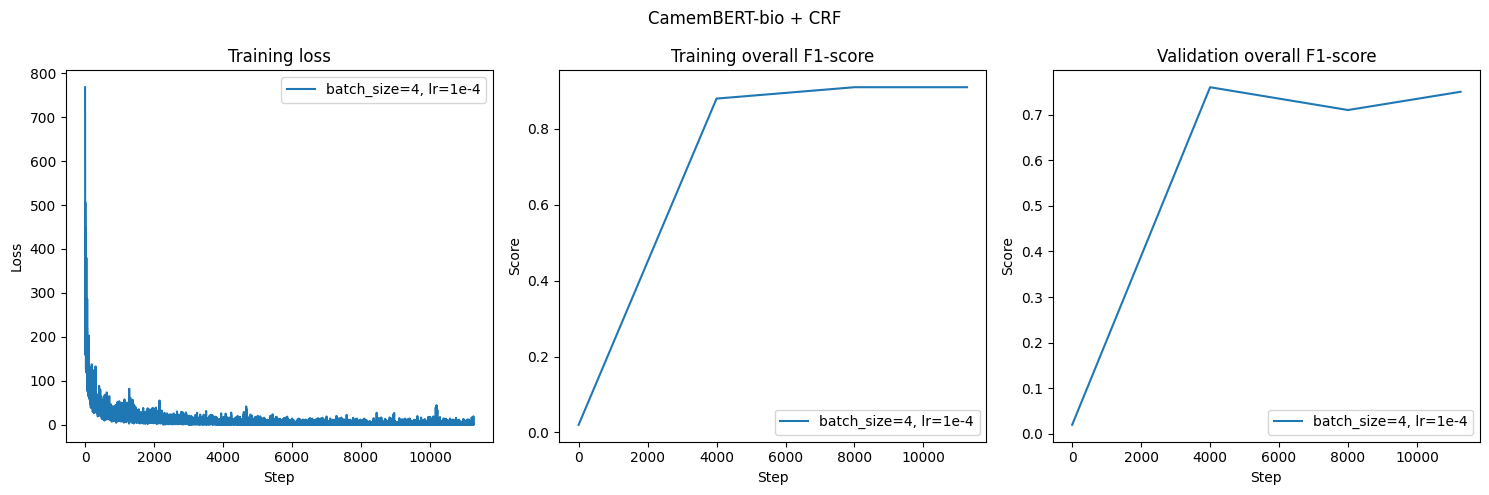

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=1e-4")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("CamemBERT-bio + CRF")

In [ ]:
nlp.to_disk("camembert_bio_crf")

### `CamemBERT-bio` + CNN

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=1e-4,
    embedding_model="almanach/camembert-bio-base",
    add_cnn=True,
    kernel_sizes=[3],
    add_crf=False,
    log_every_step=4000,
    log_train_loss=True,
)

Some weights of CamembertModel were not initialized from the model checkpoint at almanach/camembert-bio-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-06 05:25:06.190 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 05:25:07.791 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 05:25:09.542 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 05:25:11.239 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 05:25:12.991 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [17:04<00:00, 10.99it/s]  


Text(0.5, 0.98, 'CamemBERT-bio + CNN')

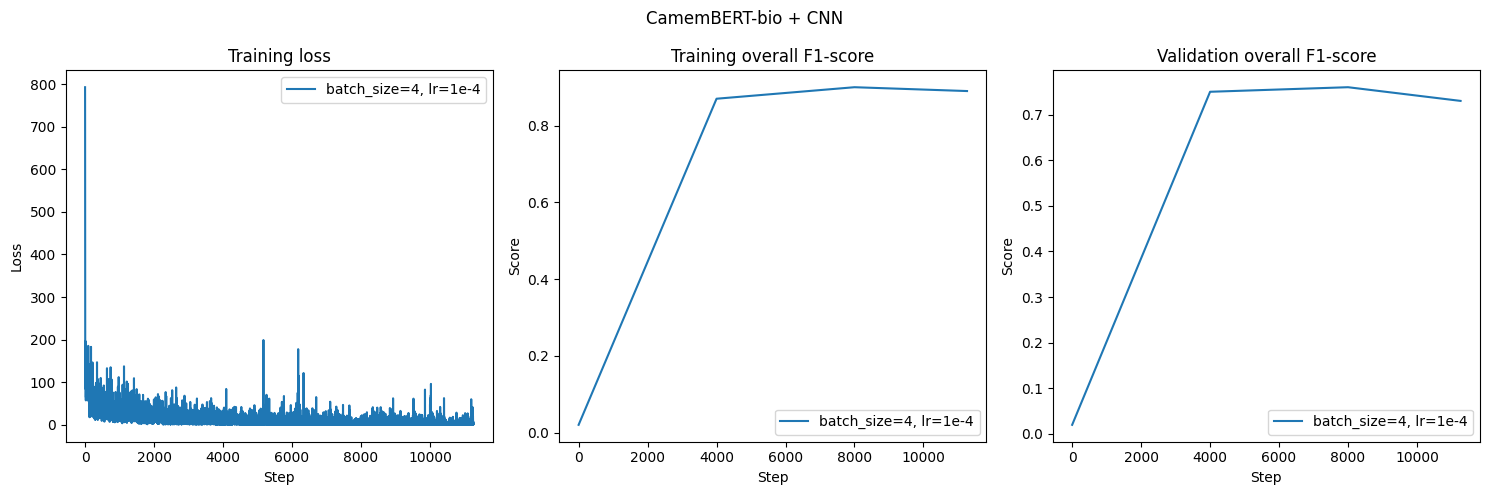

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=1e-4")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("CamemBERT-bio + CNN")

In [ ]:
nlp.to_disk("camembert_bio_cnn")

#### `CamemBERT-bio` + CRF + CNN

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=1e-4,
    embedding_model="almanach/camembert-bio-base",
    add_cnn=True,
    kernel_sizes=[3],
    add_crf=True,
    log_every_step=4000,
    log_train_loss=True,
)

Some weights of CamembertModel were not initialized from the model checkpoint at almanach/camembert-bio-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-06 05:42:23.281 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 05:42:25.160 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 05:42:27.140 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 05:42:28.784 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 05:42:31.033 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [19:01<00:00,  9.87it/s]  


Text(0.5, 0.98, 'CamemBERT-bio + CRF + CNN')

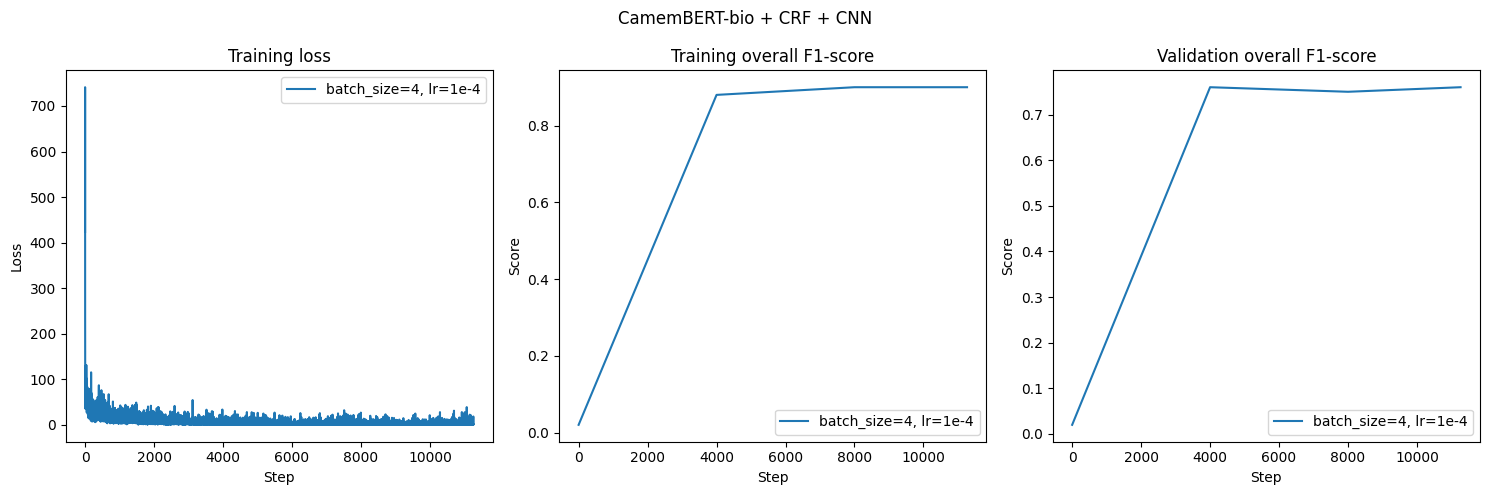

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=1e-4")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=1e-4",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("CamemBERT-bio + CRF + CNN")

In [ ]:
nlp.to_disk("camembert_bio_crf_cnn")

#### `DrBERT`

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=5e-5,
    embedding_model="Dr-BERT/DrBERT-7GB",
    add_cnn=False,
    kernel_sizes=None,
    add_crf=False,
    log_every_step=4000,
    log_train_loss=True,
)

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of CamembertModel were not initialized from the model checkpoint at Dr-BERT/DrBERT-7GB and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/791k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

2025-04-06 06:01:44.213 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:01:46.217 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 06:01:48.148 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:01:49.501 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 06:01:51.378 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [15:57<00:00, 11.77it/s]  


Text(0.5, 0.98, 'DrBERT')

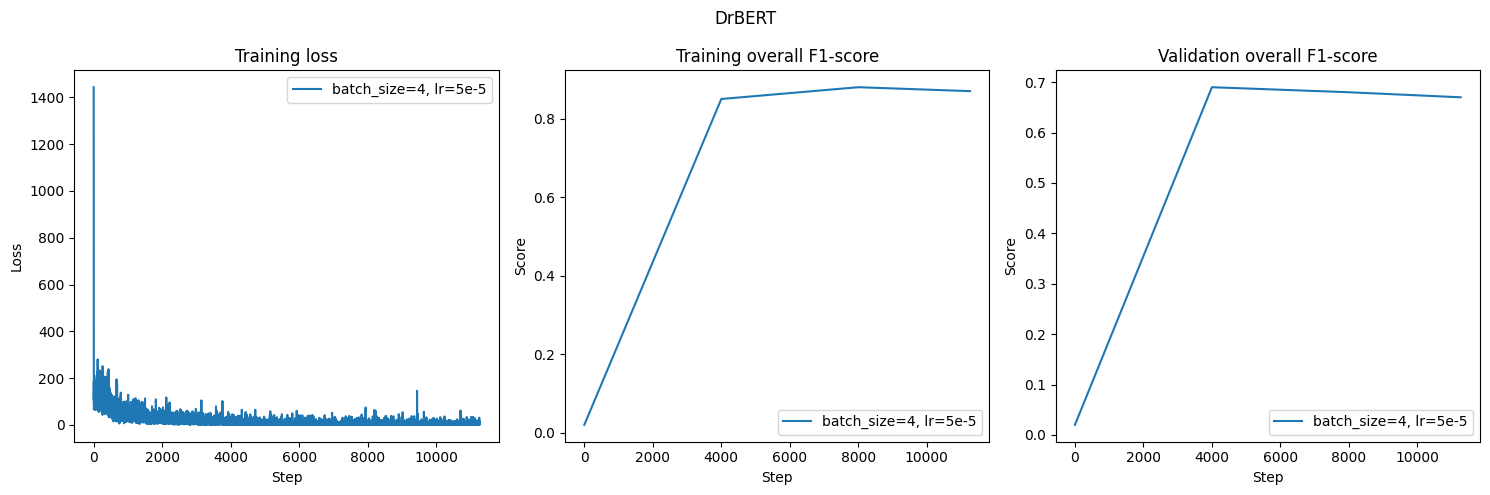

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=5e-5")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("DrBERT")

In [ ]:
nlp.to_disk("drbert")

#### `DrBERT` + CRF

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=5e-5,
    embedding_model="Dr-BERT/DrBERT-7GB",
    add_cnn=False,
    kernel_sizes=None,
    add_crf=True,
    log_every_step=4000,
    log_train_loss=True,
)

Some weights of CamembertModel were not initialized from the model checkpoint at Dr-BERT/DrBERT-7GB and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-06 06:17:55.420 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:17:57.801 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 06:17:59.472 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:18:00.706 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 06:18:02.477 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [18:11<00:00, 10.32it/s]  


Text(0.5, 0.98, 'DrBERT + CRF')

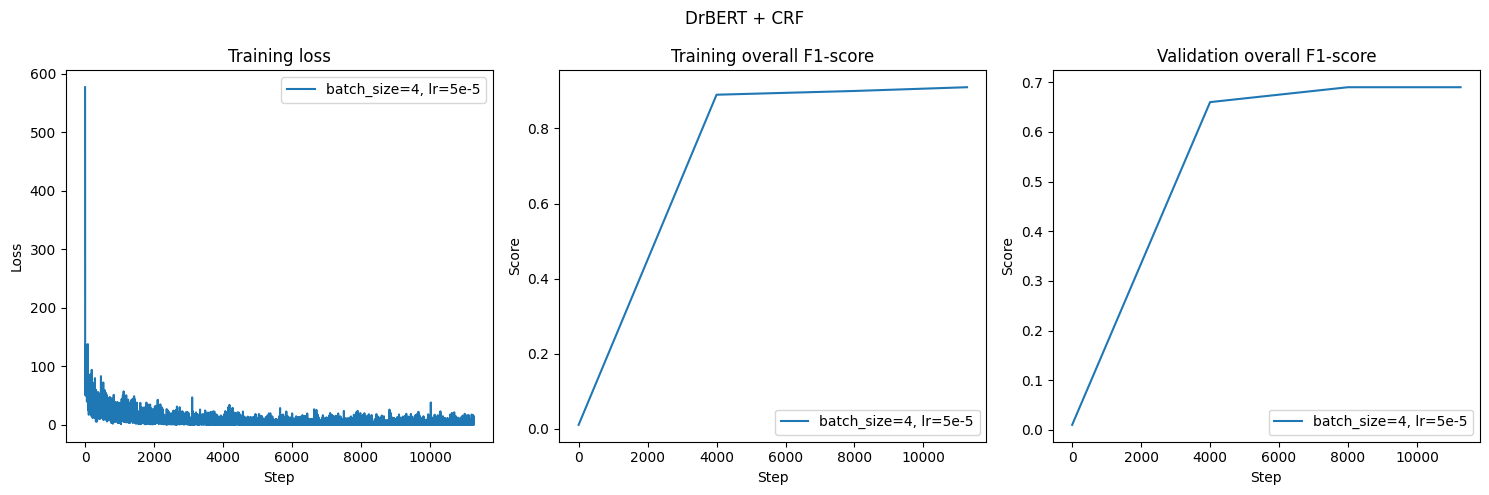

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=5e-5")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("DrBERT + CRF")

In [ ]:
nlp.to_disk("drbert_crf")

#### `DrBERT` + CNN

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=5e-5,
    embedding_model="Dr-BERT/DrBERT-7GB",
    add_cnn=True,
    kernel_sizes=[3],
    add_crf=False,
    log_every_step=4000,
    log_train_loss=True,
)

Some weights of CamembertModel were not initialized from the model checkpoint at Dr-BERT/DrBERT-7GB and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-06 06:36:19.358 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:36:21.002 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 06:36:22.751 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:36:24.061 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 06:36:25.954 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [17:49<00:00, 10.54it/s]  


Text(0.5, 0.98, 'DrBERT + CNN')

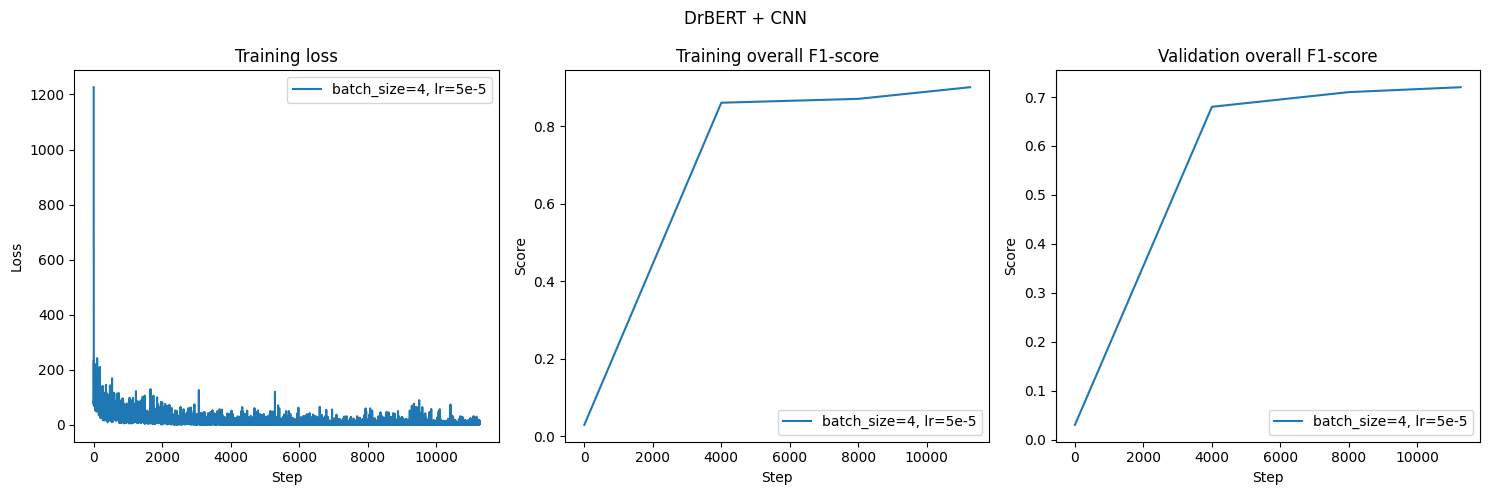

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=5e-5")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("DrBERT + CNN")

In [ ]:
nlp.to_disk("drbert_cnn")

#### `DrBERT` + CRF + CNN

In [ ]:
nlp, train_losses, train_scores, val_scores = train_NER(
    batch_size=4,
    n_epochs=15,
    lr=5e-5,
    embedding_model="Dr-BERT/DrBERT-7GB",
    add_cnn=True,
    kernel_sizes=[3],
    add_crf=True,
    log_every_step=4000,
    log_train_loss=True,
)

Some weights of CamembertModel were not initialized from the model checkpoint at Dr-BERT/DrBERT-7GB and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-06 06:54:20.961 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:54:22.597 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 06:54:24.425 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 06:54:25.833 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.
2025-04-06 06:54:28.335 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 12 .txt files.
Training model: 100%|██████████| 11265/11265 [31:04<00:00,  6.04it/s]  


Text(0.5, 0.98, 'DrBERT + CRF + CNN')

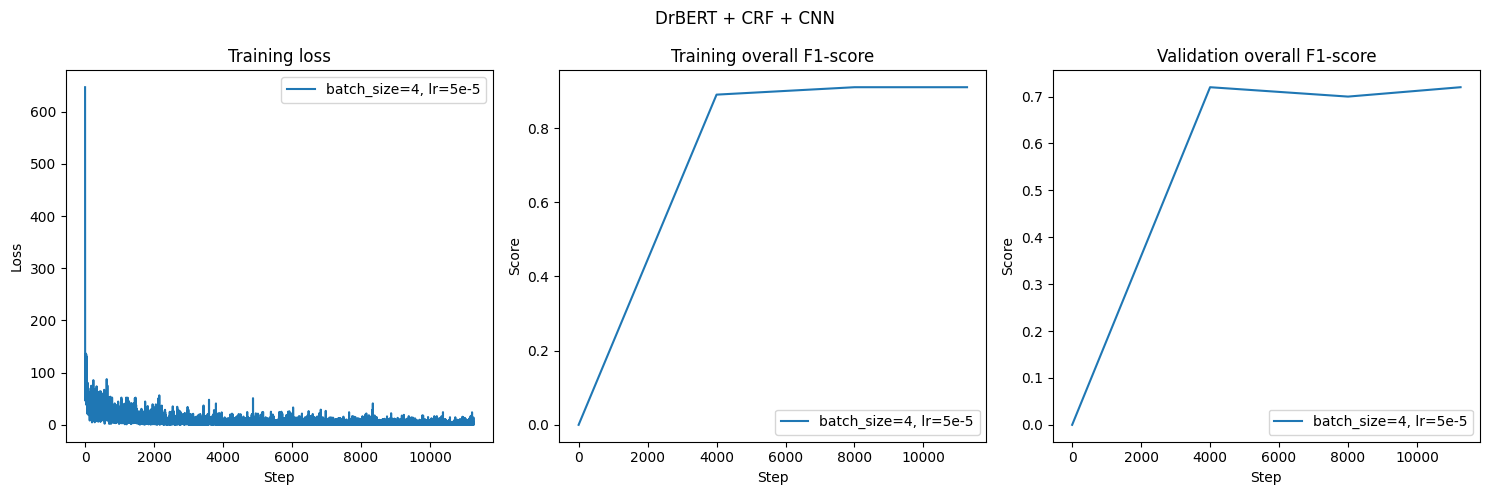

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout="tight")

plot_training_loss(axs[0], train_losses, title=f"batch_size=4, lr=5e-5")
plot_metrics(
    axs[1],
    train_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)
plot_metrics(
    axs[2],
    val_scores,
    label="overall",
    title=f"batch_size=4, lr=5e-5",
)

axs[0].set_title("Training loss")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Training overall F1-score")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Score")
axs[1].legend()

axs[2].set_title("Validation overall F1-score")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Score")
axs[2].legend()

fig.suptitle("DrBERT + CRF + CNN")

In [ ]:
nlp.to_disk("drbert_crf_cnn")

#### Final comparison on `EMEA` test

In [ ]:
# CamemBERT-bio
nlp = edsnlp.load("/kaggle/working/camembert_bio")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
camembert_bio = model_result(
    nlp,
    test_docs,
    column_name="CamemBERT-bio",
    matching_mode="exact",
    score_type="f1",
)

# CamemBERT-bio + CRF
nlp = edsnlp.load("/kaggle/working/camembert_bio_crf")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
camembert_bio_crf = model_result(
    nlp,
    test_docs,
    column_name="CamemBERT-bio + CRF",
    matching_mode="exact",
    score_type="f1",
)

# CamemBERT-bio + CNN
nlp = edsnlp.load("/kaggle/working/camembert_bio_cnn")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
camembert_bio_cnn = model_result(
    nlp,
    test_docs,
    column_name="CamemBERT-bio + CNN",
    matching_mode="exact",
    score_type="f1",
)

# CamemBERT-bio + CRF + CNN
nlp = edsnlp.load("/kaggle/working/camembert_bio_crf_cnn")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
camembert_bio_crf_cnn = model_result(
    nlp,
    test_docs,
    column_name="CamemBERT-bio + CRF + CNN",
    matching_mode="exact",
    score_type="f1",
)

# DrBERT
nlp = edsnlp.load("/kaggle/working/drbert")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
drbert = model_result(
    nlp,
    test_docs,
    column_name="DrBERT",
    matching_mode="exact",
    score_type="f1",
)

# DrBERT + CRF
nlp = edsnlp.load("/kaggle/working/drbert_crf")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
drbert_crf = model_result(
    nlp,
    test_docs,
    column_name="DrBERT + CRF",
    matching_mode="exact",
    score_type="f1",
)

# DrBERT + CNN
nlp = edsnlp.load("/kaggle/working/drbert_cnn")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
drbert_cnn = model_result(
    nlp,
    test_docs,
    column_name="DrBERT + CNN",
    matching_mode="exact",
    score_type="f1",
)

# DrBERT + CRF + CNN
nlp = edsnlp.load("/kaggle/working/drbert_crf_cnn")
test_docs = list(
    convert_brat_to_doc(
        "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/EMEA",
        nlp,
        skip_empty=False,  # Keep empty docs for an objective evaluation
        split=True,
    )
)
drbert_crf_cnn = model_result(
    nlp,
    test_docs,
    column_name="DrBERT + CRF + CNN",
    matching_mode="exact",
    score_type="f1",
)

scores = pd.concat(
    [
        camembert_bio,
        camembert_bio_crf,
        camembert_bio_cnn,
        camembert_bio_crf_cnn,
        drbert,
        drbert_crf,
        drbert_cnn,
        drbert_crf_cnn,
    ],
    axis=1,
)
display(scores)

2025-04-06 08:23:55.297 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:24:39.353 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:25:25.504 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:26:11.113 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:26:58.417 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:27:40.092 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:28:22.920 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.
2025-04-06 08:29:06.236 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 15 .txt files.


,CamemBERT-bio,CamemBERT-bio + CRF,CamemBERT-bio + CNN,CamemBERT-bio + CRF + CNN,DrBERT,DrBERT + CRF,DrBERT + CNN,DrBERT + CRF + CNN
overall,0.64,0.65,0.67,0.66,0.62,0.63,0.64,0.65
ANAT,0.83,0.79,0.88,0.85,0.80,0.84,0.87,0.86
CHEM,0.60,0.70,0.67,0.69,0.66,0.60,0.63,0.63
DEVI,0.47,0.46,0.54,0.55,0.34,0.49,0.48,0.64
DISO,0.55,0.51,0.55,0.55,0.49,0.58,0.57,0.48
GEOG,0.69,0.89,0.82,0.64,0.75,0.80,0.85,0.66
LIVB,0.82,0.75,0.83,0.77,0.79,0.76,0.71,0.83
OBJC,0.20,0.20,0.18,0.07,0.09,0.10,0.16,0.12
PHEN,0.23,0.27,0.24,0.10,0.26,0.17,0.27,0.29
PHYS,0.61,0.50,0.67,0.57,0.47,0.60,0.63,0.61


**Some comments on the results:**
* I would like to note that, because I did not thoroughly tune the hyperparameters of each model, the results in the table above may not reflect the models' best performance. For example, the `DrBERT` model achieves its best performance on the validation dataset around the 4000th step (approximately the 5th or 6th epoch). This is also relative, as I only evaluated the models on the validation dataset every 4000 steps due to the fact that the evaluations are performed on CPU, which makes each evaluation time-consuming. However, the performance shown above are not far from the best (this can be oberseved from the training plots).
  
*  It is noticeable that the F1-scores for the two labels,`OBJC` and `PHEN`, are significantly low compared to other labels. This issue may be due to the imbalance in the number of entities per label in the training dataset (please refer to the cell below for supporting evidence). It can be observed that the total numbers of entities for `OBJC` and `PHEN` are 172 and 179, respectively, out of a total of 11,860 entities. However, `DEVI` and `GEOG` have approximately the same numbers of entities, with 176 and 154 entities respectively, yet their results are much better. This may be explained by the fact that maybe the model are not fully trained, and the performance for `OBJC` and `PHEN` could be improved with additional training epochs.

*  Adding CNN layers to both architectures, `CamemBERT-bio` and `DrBERT`, could slightly improve the performance (for `CamemBERT-bio`, the performance on the `GEOG` label is significantly improved, similarly on the `PHYS` label with `DrBERT`). On the other hand, using a CRF layer may deteriorate the performance of `CamemBERT-bio` (only 4 out of 10 labels showed improvement, but this helps substantially boost the performance on the `GEOG` label), while it enhances the performance of `DrBERT`. Therefore, as we can see, adding a CRF layer, even when combined with CNN layers, tends to degrade the performance of `CamemBERT-bio`. Interestingly, one might expect that if adding a CRF layer improves the performance of `DrBERT`, then combining it with CNN layers would lead to even better results. However, in practice, the opposite is observed, where `DrBERT + CNN` performs better than `DrBERT + CRF + CNN`.

*  Finally, overall, `CamemBERT-bio` performs better than `DrBERT`, and the best performance is achieved by `CamemBERT-bio` with additional CNN layers.

In [ ]:
nlp = edsnlp.blank("eds")
medline_train = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/MEDLINE",
    nlp,
    split=False,
)
medline_dev = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/dev/MEDLINE",
    nlp,
    split=False,
)
medline_test = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/test/MEDLINE",
    nlp,
    split=False,
)
emea_train = convert_brat_to_doc(
    "/kaggle/input/quaero/QUAERO_FrenchMed/corpus/train/EMEA",
    nlp,
    split=True,
)
train_docs = (
    list(medline_train) + list(medline_dev) + list(medline_test) + list(emea_train)
)
evaluate(true_docs=train_docs, pred_docs=train_docs, matching_mode="exact")

2025-04-06 08:37:40.982 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 08:37:42.821 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 832 .txt files.
2025-04-06 08:37:44.589 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 833 .txt files.
2025-04-06 08:37:45.953 | INFO     | edsnlp.data.standoff:__init__:318 - The BRAT directory contains 11 .txt files.


{'overall': {'TP': 11860,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'ANAT': {'TP': 1748,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'CHEM': {'TP': 1783,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'DEVI': {'TP': 176,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'DISO': {'TP': 3646,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'GEOG': {'TP': 154,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'LIVB': {'TP': 1219,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'OBJC': {'TP': 172,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'PHEN': {'TP': 179,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'PHYS': {'TP': 591,
  'FP': 0,
  'FN': 0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'PROC': {'TP': 2192,
  'FP': 0,
  'FN': 0,
  'prec